## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit

import cupy as cp
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import logging
import geopandas as gpd
import xarray as xr
import salem

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(SEED)
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

## Gries:

### Create grid:

In [4]:
rgi_Gries = rgi_df.loc['gries']['rgi_id.v6']
data_gries = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
# data = data[(data.PERIOD == 'annual') & (data.RGIId == rgi_Gries)]
data_gries = data_gries[data_gries.RGIId == rgi_Gries]

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2024-08-26 12:45:08: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-26 12:45:08: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-26 12:45:08: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-08-26 12:45:08: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-08-26 12:45:08: oggm.cfg: Multiprocessing switched ON after user settings.
2024-08-26 12:45:08: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [5]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2024-08-26 12:45:09: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2024-08-26 12:45:09: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2024-08-26 12:45:27: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers
2024-08-26 12:45:36: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 3927 glaciers


In [6]:
# Get info of that sample:
# POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == rgi_Gries:
        break
# gdir = find_gdir(gdirs, RGI)

with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

<xarray.Dataset> Size: 798kB
Dimensions:                  (x: 119, y: 103)
Coordinates:
  * x                        (x) float32 476B -2.236e+03 -2.194e+03 ... 2.72e+03
  * y                        (y) float32 412B 5.145e+06 5.145e+06 ... 5.141e+06
Data variables: (12/20)
    topo                     (y, x) float32 49kB 2.116e+03 ... 2.762e+03
    topo_smoothed            (y, x) float32 49kB 2.142e+03 2.145e+03 ... 2.8e+03
    topo_valid_mask          (y, x) int8 12kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 12kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 12kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 49kB nan nan nan nan ... nan nan nan
    ...                       ...
    aspect                   (y, x) float32 49kB 5.901 5.741 ... 1.939 2.138
    slope_factor             (y, x) float32 49kB 2.767 2.743 2.6 ... 2.122 2.393
    dis_from_border          (y, x) float32 49kB 2.271e+03 ... 2.571e+03
    catchment_area           (y, x) float32 49kB nan nan nan nan ... nan nan nan
    lin_mb_above_z           (y, x) float32 49kB nan nan nan nan ... nan nan nan
    oggm_mb_above_z          (y, x) float32 49kB nan nan nan nan ... nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=8.33019 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      3342.0
    min_h_dem:      2116.0
    max_h_glacier:  3300.0
    min_h_glacier:  2424.0

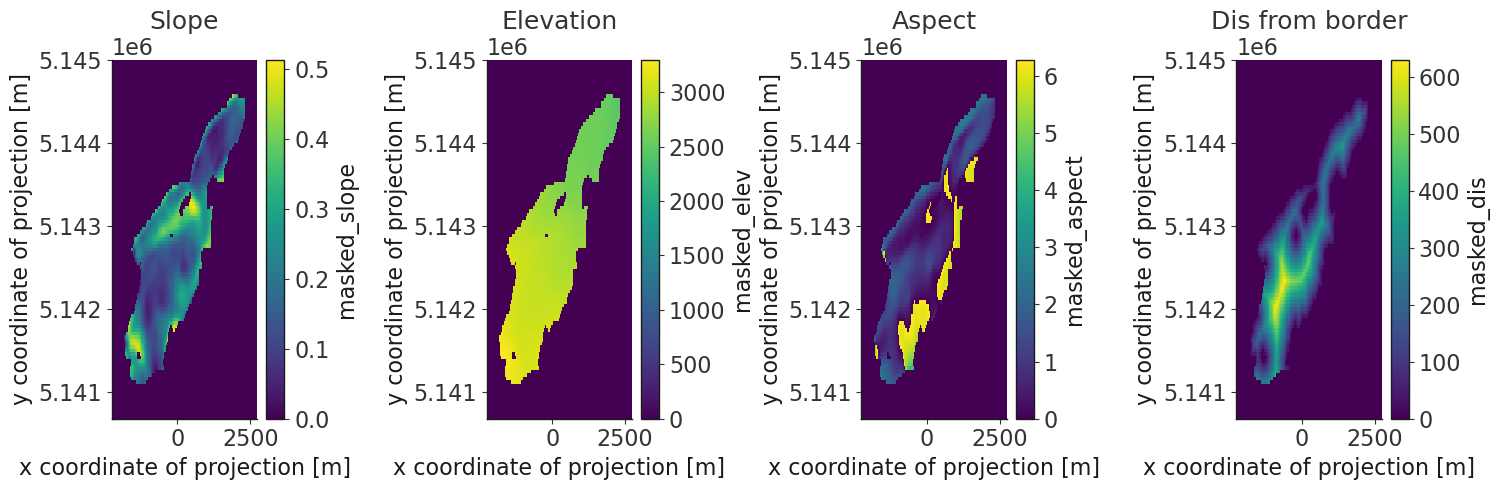

In [7]:
# Assuming ds is your xarray dataset and 'glacier_mask' and 'topo' are the variable names
ds = ds.assign(masked_slope=ds['glacier_mask'] * ds['slope'])
ds = ds.assign(masked_elev=ds['glacier_mask'] * ds['topo'])
ds = ds.assign(masked_aspect=ds['glacier_mask'] * ds['aspect'])
ds = ds.assign(masked_dis=ds['glacier_mask'] * ds['dis_from_border'])
glacier_indices = np.where(ds['glacier_mask'].values == 1)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ds.masked_slope.plot(ax=ax[0])
ax[0].set_title('Slope')
ds.masked_elev.plot(ax=ax[1])
ax[1].set_title('Elevation')
ds.masked_aspect.plot(ax=ax[2])
ax[2].set_title('Aspect')
ds.masked_dis.plot(ax=ax[3])
ax[3].set_title('Dis from border')
plt.tight_layout()

In [8]:
# Assuming the coordinate variables are named 'x' and 'y' in your dataset
x_coords = ds['x'].values
y_coords = ds['y'].values

# Retrieve the x and y values using the glacier indices
glacier_x_vals = x_coords[glacier_indices[1]]
glacier_y_vals = y_coords[glacier_indices[0]]
print("Glacier x-coordinates:", glacier_x_vals)
print("Glacier y-coordinates:", glacier_y_vals)

# Convert glacier coordinates to latitude and longitude
# Transform stake coord to glacier system:
transf = pyproj.Transformer.from_proj(gdir.grid.proj,
                                      salem.wgs84,
                                      always_xy=True)
lon, lat = transf.transform(glacier_x_vals, glacier_y_vals)
print("Latitude coordinates:", lat)
print("Longitude coordinates:", lon)

# Glacier mask as boolean array:
gl_mask_bool = ds['glacier_mask'].values.astype(bool)

# Create a DataFrame
data_grid = {
    'RGIId': [rgi_Gries] * len(ds.masked_elev.values[gl_mask_bool]),
    'POINT_LAT': lat,
    'POINT_LON': lon,
    'aspect': ds.masked_aspect.values[gl_mask_bool],
    'slope': ds.masked_slope.values[gl_mask_bool],
    'topo': ds.masked_elev.values[gl_mask_bool],
    'dis_from_border': ds.masked_dis.values[gl_mask_bool],
}

df_grid = pd.DataFrame(data_grid)

# Match to WGMS format:
# Create a point ID column
df_grid['POINT_ID'] = np.arange(1, len(df_grid) + 1)
df_grid["PERIOD"] = "annual"
df_grid['N_MONTHS'] = 12
df_grid['GLACIER'] = 'Gries'
df_grid['POINT_ELEVATION'] = df_grid['topo']  # no other elevation available

# fake PMB for simplicity
df_grid['POINT_BALANCE'] = 0

# Add years
years = data_gries['YEAR'].unique()
num_years = len(years)
num_rows_per_year = len(df_grid)

# Repeat the DataFrame num_years times
df_grid = pd.concat([df_grid] * num_years, ignore_index=True)

# Create a 'year' column that has num_rows_per_year instances of year
year_column = np.repeat(years, num_rows_per_year)

# Add the 'year' column to the DataFrame
df_grid['YEAR'] = year_column
df_grid['FROM_DATE'] = df_grid['YEAR'].apply(lambda x: str(x) + '1001')
df_grid['TO_DATE'] = df_grid['YEAR'].apply(lambda x: str(x + 1) + '1001')
print('length of df_grid:', len(df_grid))
df_grid.head(2)

Glacier x-coordinates: [ 1879.9048  1921.9048  1963.9048 ... -1186.0952 -1144.0952 -1102.0952]
Glacier y-coordinates: [5144568.5 5144568.5 5144568.5 ... 5141124.5 5141124.5 5141124.5]
Latitude coordinates: [46.45468569 46.45468557 46.45468545 ... 46.42369247 46.42369255
 46.42369262]
Longitude coordinates: [8.35466933 8.35521623 8.35576314 ... 8.31475392 8.31530052 8.31584712]
length of df_grid: 186000


,RGIId,POINT_LAT,POINT_LON,aspect,slope,topo,dis_from_border,POINT_ID,PERIOD,N_MONTHS,GLACIER,POINT_ELEVATION,POINT_BALANCE,YEAR,FROM_DATE,TO_DATE
0,RGI60-11.01876,46.454686,8.354669,2.560909,0.453488,2527.0,0.0,1,annual,12,Gries,2527.0,0,1962,19621001,19631001
1,RGI60-11.01876,46.454686,8.355216,2.541511,0.420521,2518.0,0.0,2,annual,12,Gries,2518.0,0,1962,19621001,19631001


Text(0.5, 1.0, 'OGGM grid and GLAMOS stakes')

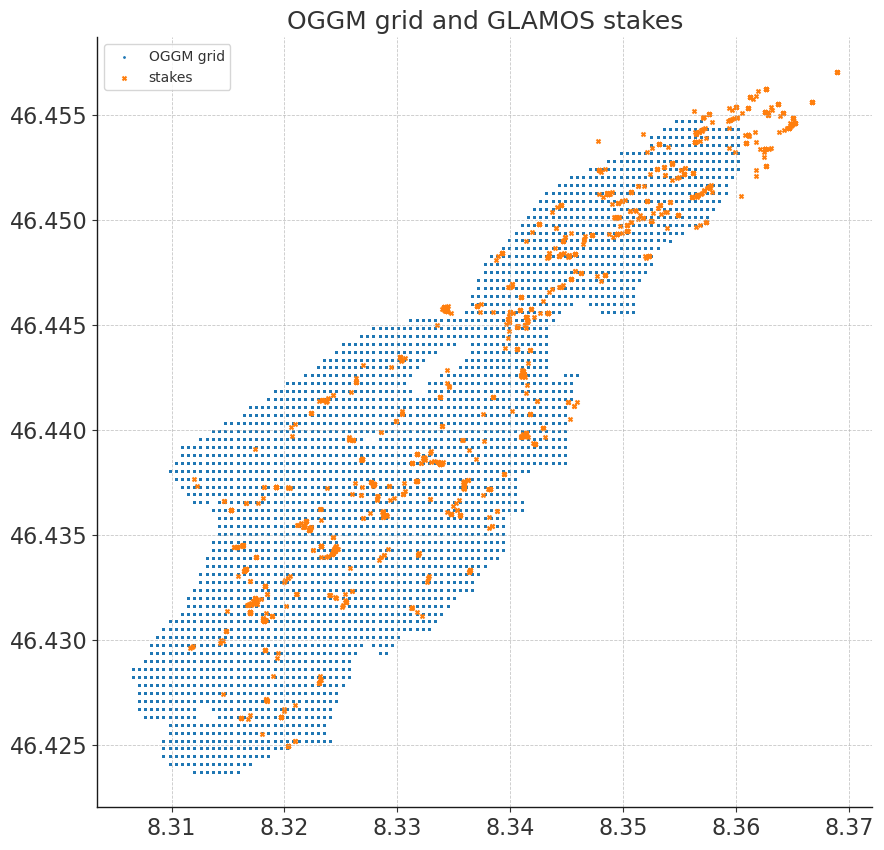

In [9]:
# Plot coordinates
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df_grid.POINT_LON, df_grid.POINT_LAT, s=1, label='OGGM grid')
ax.scatter(data_gries.POINT_LON,
           data_gries.POINT_LAT,
           s=8,
           label='stakes',
           marker='x')
ax.legend()
ax.set_title('OGGM grid and GLAMOS stakes')

### Add climate variables:

In [10]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']
meta_data_columns = ["RGIId", "POINT_ID", "ID", "N_MONTHS", "MONTHS", "PERIOD"]

RUN = False
if RUN == True:
    # Provide the column name for the column that has the RGI IDs for each of the stakes
    dataset_grid = mbm.Dataset(data=df_grid,
                               region_name='CH',
                               data_path=path_PMB_GLAMOS_csv)

    # Add climate data:
    # Specify the files of the climate data, that will be matched with the coordinates of the stake data
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

    # Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
    dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                      geopotential_data=geopotential_data,
                                      change_units=True)

    # For each record, convert to a monthly time resolution
    dataset_grid.convert_to_monthly(meta_data_columns=meta_data_columns,
                                    vois_climate=vois_climate,
                                    vois_topographical=voi_topographical)

    # Save grid:
    dataset_grid.data.to_csv(path_glacier_grid + 'Gries_grid.csv', index=False)

else:
    dataset_grid = pd.read_csv(path_glacier_grid + 'Gries_grid.csv')

# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=dataset_grid,
                            random_seed=SEED,
                            meta_data_columns=meta_data_columns)

### Train model:

Number of winter and annual samples: 1943
Number of annual samples: 1646
Number of winter samples: 297


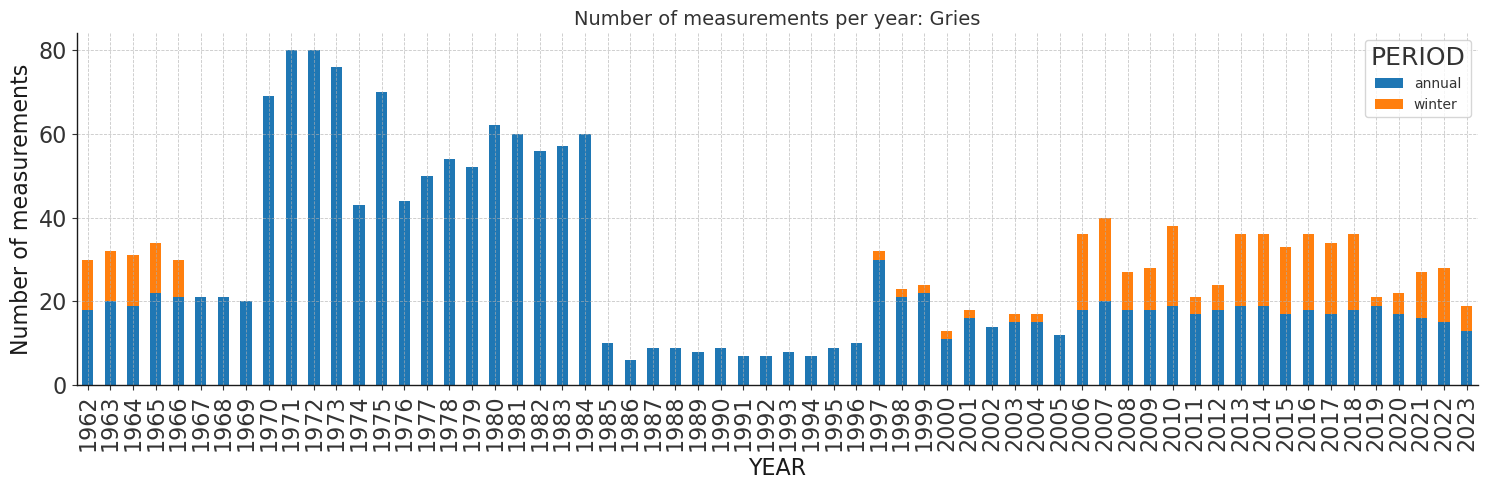

In [18]:
rgi_Gries = rgi_df.loc['gries']['rgi_id.v6']

data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
# data = data[(data.PERIOD == 'annual') & (data.RGIId == rgi_Gries)]
data = data[data.RGIId == rgi_Gries]

print('Number of winter and annual samples:', len(data))
print('Number of annual samples:', len(data[data.PERIOD == 'annual']))
print('Number of winter samples:', len(data[data.PERIOD == 'winter']))

# change mm w.e. to m w.e.
data['POINT_BALANCE'] = data['POINT_BALANCE'] / 1000

# Plot number of measurements per year
# Number of measurements per glacier per year:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
num_gl_yr = data.groupby(['YEAR', 'PERIOD']).size().unstack().reset_index()
num_gl_yr.plot(x='YEAR', kind='bar', stacked=True, ax=ax, title='Gries')
ax.set_ylabel('Number of measurements')
ax.set_title('Number of measurements per year: Gries', fontsize=14)
plt.tight_layout()

Train years: [1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1973 1974 1975 1976
 1977 1978 1980 1981 1982 1983 1984 1986 1988 1989 1991 1992 1996 1997
 1998 1999 2000 2001 2005 2006 2007 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2020 2021 2022 2023]
Test years: [1972 1979 1985 1987 1990 1993 1994 1995 2002 2003 2004 2008 2019]


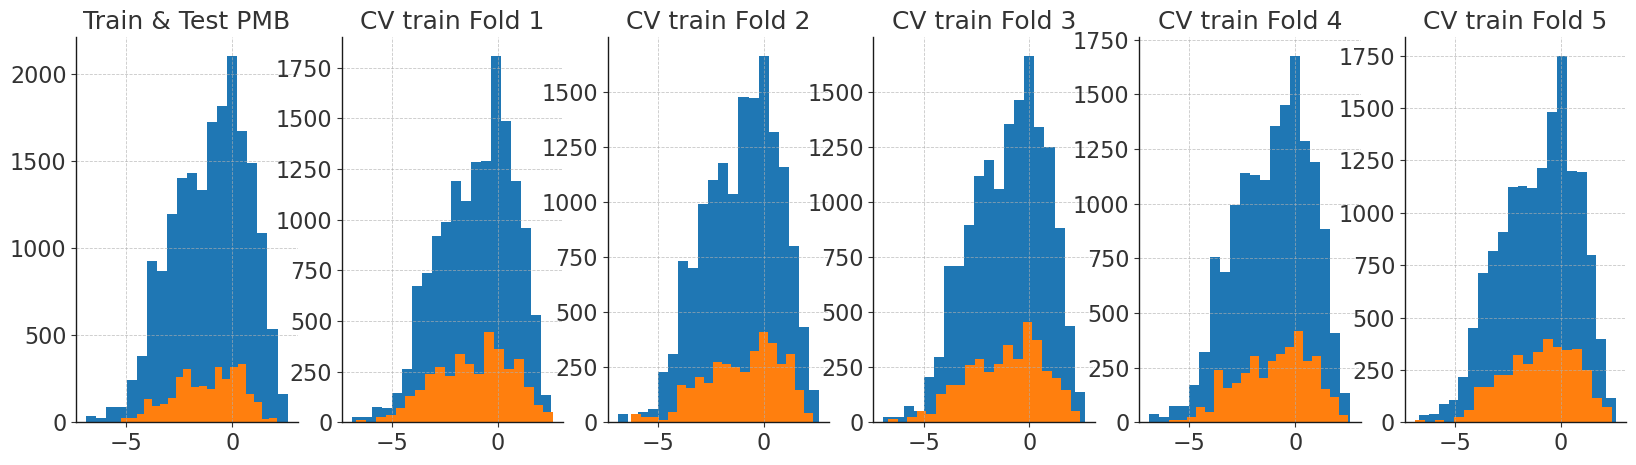

In [19]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']
meta_data_columns = ["RGIId", "POINT_ID", "ID", "N_MONTHS", "MONTHS", "PERIOD"]

# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data,
                             change_units=True)

# For each record, convert to a monthly time resolution
dataset.convert_to_monthly(meta_data_columns=meta_data_columns,
                           vois_climate=vois_climate,
                           vois_topographical=voi_topographical)

# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=dataset.data,
                            random_seed=SEED,
                            meta_data_columns=meta_data_columns)
TYPE_SPLIT = 'year'

if TYPE_SPLIT == 'year':
    # Split into training and test years with train_test_split
    train_years, test_years = train_test_split(dataset.data.YEAR.unique(),
                                               test_size=0.2,
                                               random_state=SEED)

    train_indices = dataset.data[dataset.data.YEAR.isin(train_years)].index
    test_indices = dataset.data[dataset.data.YEAR.isin(test_years)].index

    dataloader.set_custom_train_test_indices(train_indices, test_indices)

else:
    # Randomly (though does not separate meas ID)
    train_itr, test_itr = dataloader.set_train_test_split(test_size=0.2,
                                                          shuffle=True)

    train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = dataset.data.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = dataset.data.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Create the CV splits based on the training dataset. The default value for the number of splits is 5.
splits = dataloader.get_cv_split(n_splits=5, type_fold='group-meas-id')
test_meas_id = df_X_test['ID'].unique()

# Years in training and test set
train_years = df_X_train.YEAR.unique()
test_years = df_X_test.YEAR.unique()
print('Train years:', train_years)
print('Test years:', test_years)

# Plot splits
visualiseSplits(y_test, y_train, splits)

In [20]:
%%time
# Grid search
# For each of the XGBoost parameter, define the grid range
parameters = {
    'max_depth': [
        3,
        4,
        5,
        6,
    ],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1]
}

feature_columns = [
    'ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf',
    'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp'
]

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = SEED

# Create a CustomXGBoostRegressor instance
custom_xgboost = mbm.models.CustomXGBoostRegressor(
    meta_data_columns=meta_data_columns, **param_init)
custom_xgboost.randomsearch(
    parameters=parameters,
    n_iter=20,
    splits=splits,
    features=df_X_train,
    targets=y_train,
    num_jobs=-1,
    random_seed=SEED,
)

# save best model
custom_xgboost.save_model('xgb_gries.pkl')

best_params = params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:49:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:49:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:49:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:49:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters:
 {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0}
Best score:
 -0.2331405747185545
CPU times: user 2min 22s, sys: 1.32 s, total: 2min 23s
Wall time: 1min 6s


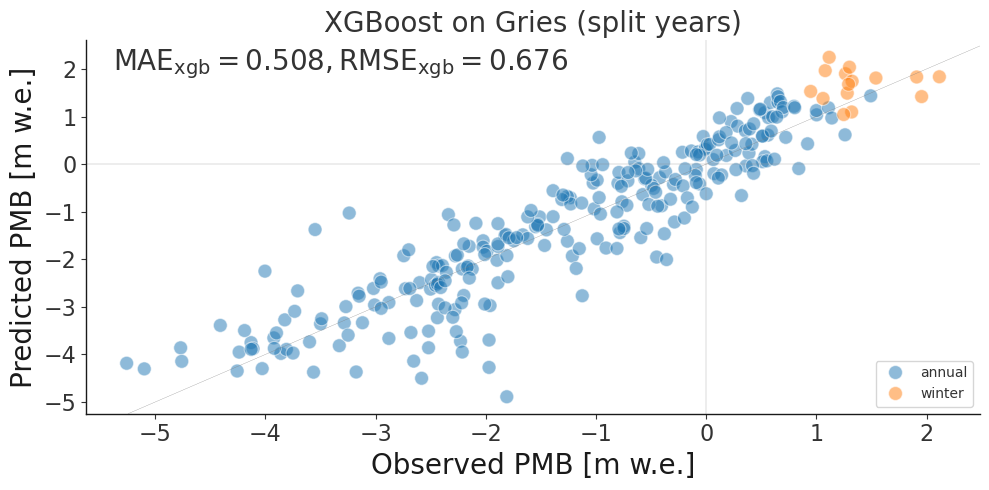

In [22]:
# Set to CPU for predictions:
xgb = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = xgb._create_features_metadata(
    df_X_test, meta_data_columns)
y_pred = xgb.predict(features_test)

# Make predictions aggr to meas ID:
y_pred_agg = xgb.aggrPredict(metadata_test, meta_data_columns, features_test)

# Calculate scores
score = xgb.score(df_X_test, y_test)  # negative
mse, rmse, mae = xgb.evalMetrics(metadata_test, y_pred, y_test)

# Aggregate predictions to annual or winter:
df_pred = df_X_test.copy()
df_pred['target'] = y_test
grouped_ids = df_pred.groupby('ID').agg({'target': 'mean'})
grouped_ids['pred'] = y_pred_agg
grouped_ids['PERIOD'] = df_X_test.groupby('ID')['PERIOD'].first()

predVSTruth(grouped_ids, mae, rmse, title='XGBoost on Gries (split years)')


### Load estimator:

In [28]:
# For each of the XGBoost parameter, define the grid range
param_init = {}
# param_init['device'] = 'cuda:0'
# param_init['tree_method'] = 'hist'
param_init["random_state"] = SEED

feature_columns = [
    'ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf',
    'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp'
]


# Create a CustomXGBoostRegressor instance
custom_xgboost = mbm.models.CustomXGBoostRegressor(
    meta_data_columns=meta_data_columns, **param_init)
clf = custom_xgboost.load_model('xgb_gries.pkl')
print('Params:', clf.best_params_)
xgb = clf.best_estimator_

# Make predictions:
print('Shape of test data:', dataset_grid.shape)

# Set to CPU for predictions:
xgb = xgb.set_params(device='cpu')

# Make predictions on test
features_grid, metadata_grid = xgb._create_features_metadata(
    dataset_grid, meta_data_columns)
y_pred_grid = xgb.predict(features_grid)

# Make predictions aggr to meas ID:
y_pred_grid_agg = xgb.aggrPredict(metadata_grid, meta_data_columns, features_grid)

Params: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0}
Shape of test data: (2418000, 21)


(array([4.950000e+02, 5.488000e+03, 2.735700e+04, 6.270100e+04,
        1.158820e+05, 2.060970e+05, 3.336200e+05, 1.148769e+06,
        5.171500e+05, 4.410000e+02]),
 array([-2.37347984, -2.05170274, -1.72992575, -1.40814877, -1.08637166,
        -0.76459467, -0.4428176 , -0.12104057,  0.20073648,  0.52251351,
         0.84429055]),
 <BarContainer object of 10 artists>)

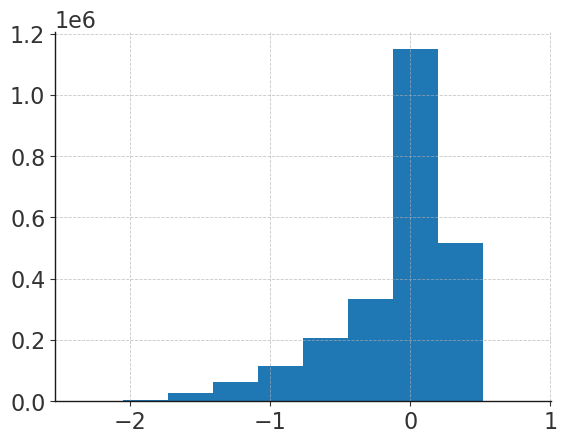

In [29]:
plt.hist(y_pred_grid)

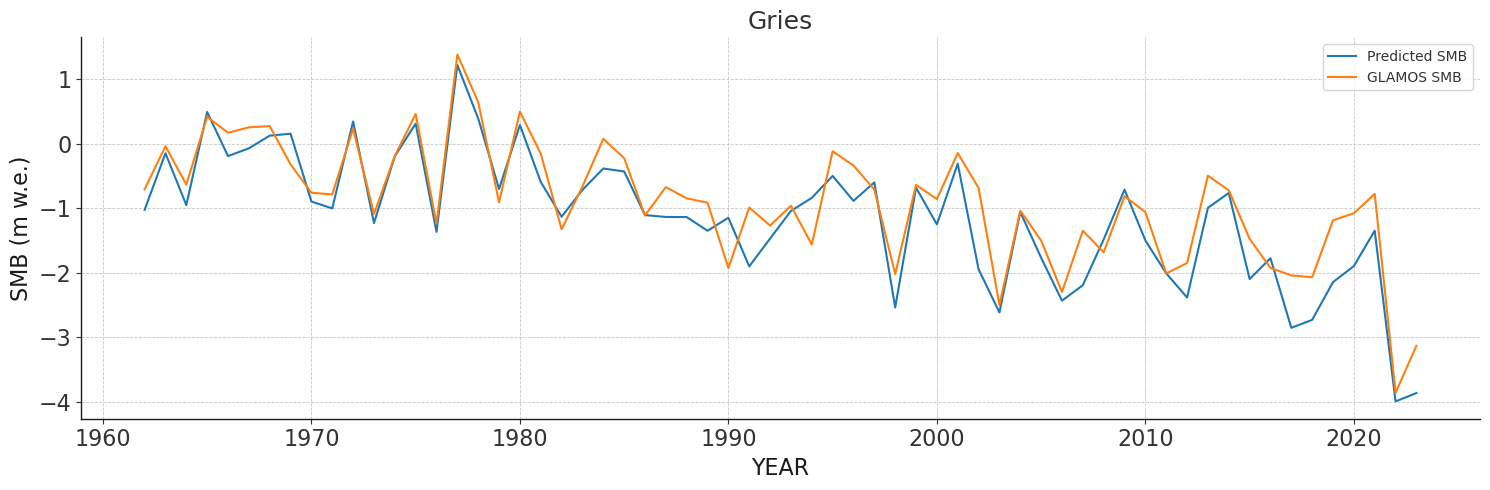

In [30]:
# Aggregate predictions to annual or winter:
grouped_ids = dataset_grid.groupby('ID').agg({'YEAR': 'mean'})
grouped_ids['pred'] = y_pred_grid_agg

# Sum over all points of a glacier to get glacier wide SMB
grouped_ids = grouped_ids.groupby('YEAR').mean()

df_target = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + 'gries_fix.csv')
df_target = transformDates(df_target)
# Remove obvious duplicates:
df_target = df_target.drop_duplicates()
df_target['YEAR'] = df_target['date1'].apply(lambda x: pd.to_datetime(x).year)
df_target['Annual Balance'] = df_target['Annual Balance'] / (1000)
df_target = df_target[['YEAR', 'Annual Balance']].set_index('YEAR')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
grouped_ids.plot(y='pred', label='Predicted SMB', ax=ax)
df_target.plot(y='Annual Balance', label='GLAMOS SMB', ax=ax)

ax.set_title('Gries')
ax.set_ylabel('SMB (m w.e.)')
plt.tight_layout()

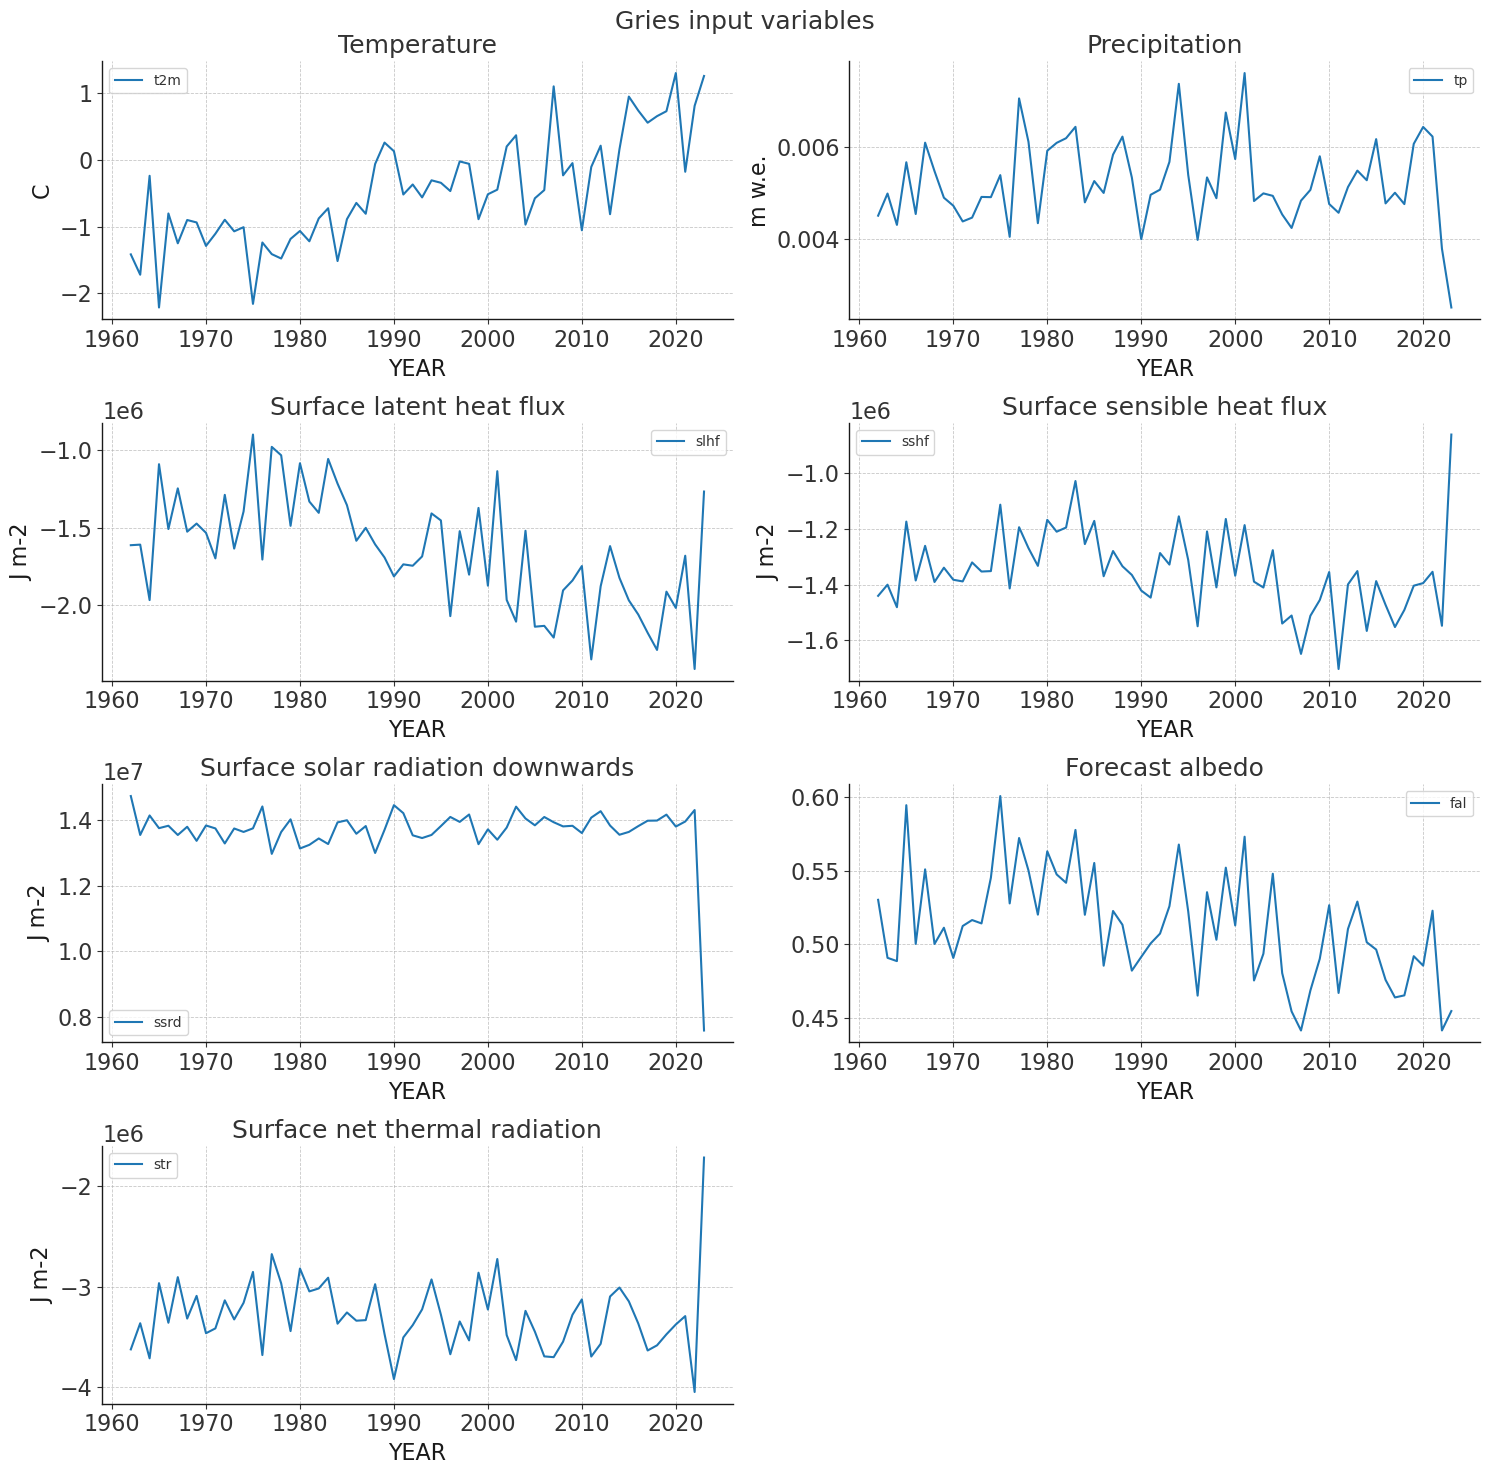

In [31]:
# Plot temperature and precipitation aggregated over grid points:
fig = plt.figure(figsize=(15, 15))
df = dataset_grid
for i, var in enumerate(vois_climate):
    temp = df[[var, 'YEAR']].groupby('YEAR').mean()
    mean = temp.mean().values
    std = temp.std().values
    ax = plt.subplot(4, 2, i + 1)
    temp.plot(ax=ax)
    ax.set_title(vois_climate_long_name[var])
    ax.set_ylabel(vois_units[var])

plt.suptitle('Gries input variables')
plt.tight_layout()

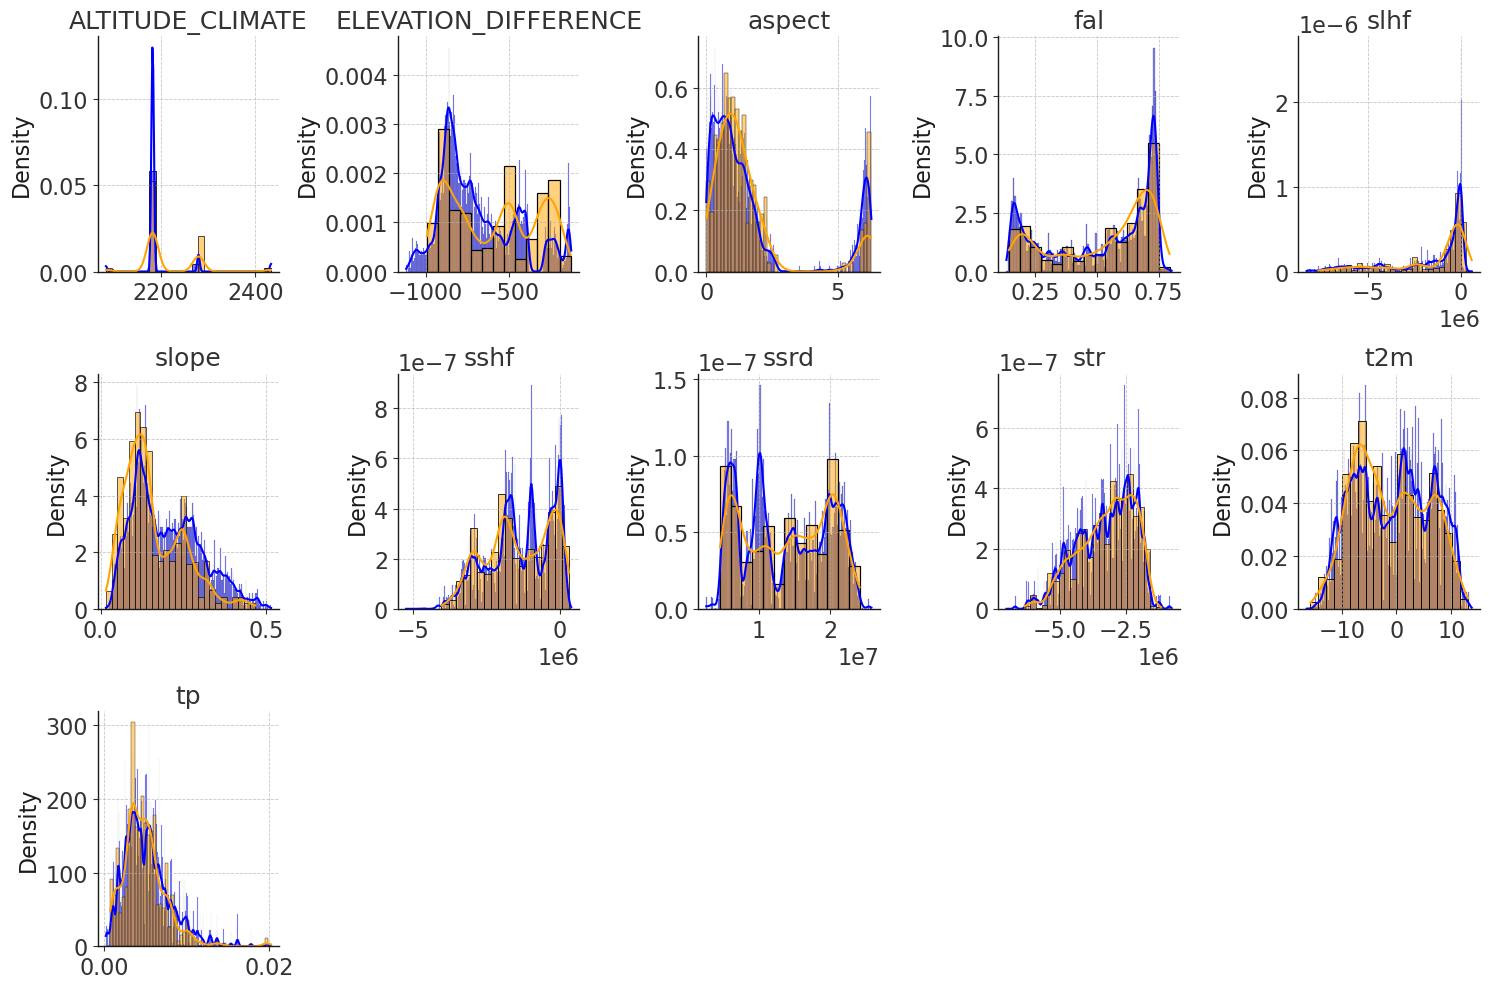

In [49]:
# Plot distribution of input variables:
fig = plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_columns):
    ax = plt.subplot(3, 5, i + 1)
    sns.histplot(data=dataset_grid[feature],
                 color='blue',
                 alpha=0.5,
                 kde=True,
                 label='Grid',
                 ax=ax,
                 stat = 'density')
    sns.histplot(data=df_X_test[feature],
                 color='orange',
                 alpha=0.5,
                 kde=True,
                 label='Stakes',
                 ax=ax,
                 stat = 'density')
    ax.legend()
    ax.set_title(feature)
    ax.set_xlabel('')
plt.tight_layout()

## Silvretta:

### Create grid:

In [61]:
rgi_glacier = rgi_df.loc['silvretta']['rgi_id.v6']
data_silvretta = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
# data = data[(data.PERIOD == 'annual') & (data.RGIId == rgi_silvretta)]
data_silvretta = data_silvretta[data_silvretta.RGIId == rgi_glacier]

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2024-08-26 13:11:46: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-26 13:11:46: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-26 13:11:46: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-08-26 13:11:46: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-08-26 13:11:46: oggm.cfg: Multiprocessing switched ON after user settings.
2024-08-26 13:11:46: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [51]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2024-08-26 13:07:28: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2024-08-26 13:07:28: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2024-08-26 13:07:47: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers
2024-08-26 13:07:57: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 3927 glaciers


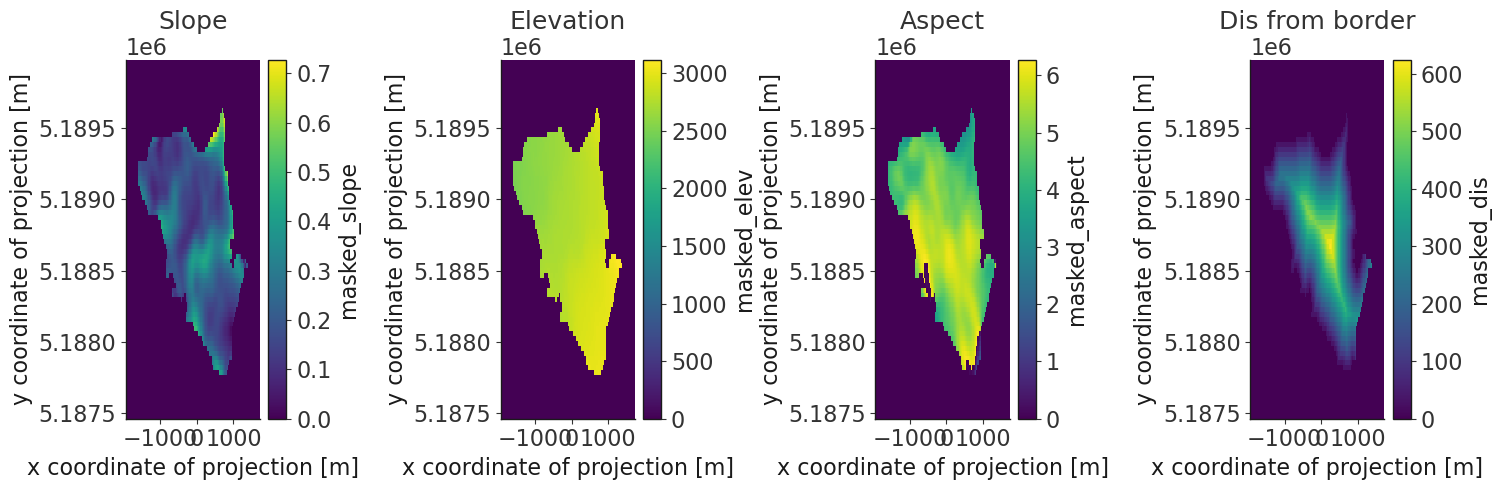

In [62]:
# Get info of that sample:
# POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == rgi_glacier:
        break
# gdir = find_gdir(gdirs, RGI)

with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
# Assuming ds is your xarray dataset and 'glacier_mask' and 'topo' are the variable names
ds = ds.assign(masked_slope=ds['glacier_mask'] * ds['slope'])
ds = ds.assign(masked_elev=ds['glacier_mask'] * ds['topo'])
ds = ds.assign(masked_aspect=ds['glacier_mask'] * ds['aspect'])
ds = ds.assign(masked_dis=ds['glacier_mask'] * ds['dis_from_border'])
glacier_indices = np.where(ds['glacier_mask'].values == 1)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ds.masked_slope.plot(ax=ax[0])
ax[0].set_title('Slope')
ds.masked_elev.plot(ax=ax[1])
ax[1].set_title('Elevation')
ds.masked_aspect.plot(ax=ax[2])
ax[2].set_title('Aspect')
ds.masked_dis.plot(ax=ax[3])
ax[3].set_title('Dis from border')
plt.tight_layout()

In [65]:
# Assuming the coordinate variables are named 'x' and 'y' in your dataset
x_coords = ds['x'].values
y_coords = ds['y'].values

# Retrieve the x and y values using the glacier indices
glacier_x_vals = x_coords[glacier_indices[1]]
glacier_y_vals = y_coords[glacier_indices[0]]
print("Glacier x-coordinates:", glacier_x_vals)
print("Glacier y-coordinates:", glacier_y_vals)

# Convert glacier coordinates to latitude and longitude
# Transform stake coord to glacier system:
transf = pyproj.Transformer.from_proj(gdir.grid.proj,
                                      salem.wgs84,
                                      always_xy=True)
lon, lat = transf.transform(glacier_x_vals, glacier_y_vals)
print("Latitude coordinates:", lat)
print("Longitude coordinates:", lon)

# Glacier mask as boolean array:
gl_mask_bool = ds['glacier_mask'].values.astype(bool)

# Create a DataFrame
data_grid = {
    'RGIId': [rgi_glacier] * len(ds.masked_elev.values[gl_mask_bool]),
    'POINT_LAT': lat,
    'POINT_LON': lon,
    'aspect': ds.masked_aspect.values[gl_mask_bool],
    'slope': ds.masked_slope.values[gl_mask_bool],
    'topo': ds.masked_elev.values[gl_mask_bool],
    'dis_from_border': ds.masked_dis.values[gl_mask_bool],
}

df_grid = pd.DataFrame(data_grid)

# Match to WGMS format:
# Create a point ID column
df_grid['POINT_ID'] = np.arange(1, len(df_grid) + 1)
df_grid["PERIOD"] = "annual"
df_grid['N_MONTHS'] = 12
df_grid['GLACIER'] = 'Silvretta'
df_grid['POINT_ELEVATION'] = df_grid['topo']  # no other elevation available

# fake PMB for simplicity
df_grid['POINT_BALANCE'] = 0

# Add years
years = data_silvretta['YEAR'].unique()
num_years = len(years)
num_rows_per_year = len(df_grid)

# Repeat the DataFrame num_years times
df_grid = pd.concat([df_grid] * num_years, ignore_index=True)

# Create a 'year' column that has num_rows_per_year instances of year
year_column = np.repeat(years, num_rows_per_year)

# Add the 'year' column to the DataFrame
df_grid['YEAR'] = year_column
df_grid['FROM_DATE'] = df_grid['YEAR'].apply(lambda x: str(x) + '1001')
df_grid['TO_DATE'] = df_grid['YEAR'].apply(lambda x: str(x + 1) + '1001')
print('length of df_grid:', len(df_grid))
df_grid.head(2)

Glacier x-coordinates: [695.64307 661.64307 695.64307 ... 729.64307 763.64307 797.64307]
Glacier y-coordinates: [5189621. 5189587. 5189587. ... 5187785. 5187785. 5187785.]
Latitude coordinates: [46.86012914 46.85982321 46.85982318 ... 46.84360694 46.84360691
 46.84360687]
Longitude coordinates: [10.08572633 10.08528023 10.08572628 ... 10.08616945 10.08661537
 10.08706129]
length of df_grid: 151524


,RGIId,POINT_LAT,POINT_LON,aspect,slope,topo,dis_from_border,POINT_ID,PERIOD,N_MONTHS,GLACIER,POINT_ELEVATION,POINT_BALANCE,YEAR,FROM_DATE,TO_DATE
0,RGI60-11.00804,46.860129,10.085726,3.458190,0.554950,3009.0,0.0,1,annual,12,Silvretta,3009.0,0,1961,19611001,19621001
1,RGI60-11.00804,46.859823,10.085280,3.187942,0.565721,2984.0,0.0,2,annual,12,Silvretta,2984.0,0,1961,19611001,19621001


Text(0.5, 1.0, 'OGGM grid and GLAMOS stakes')

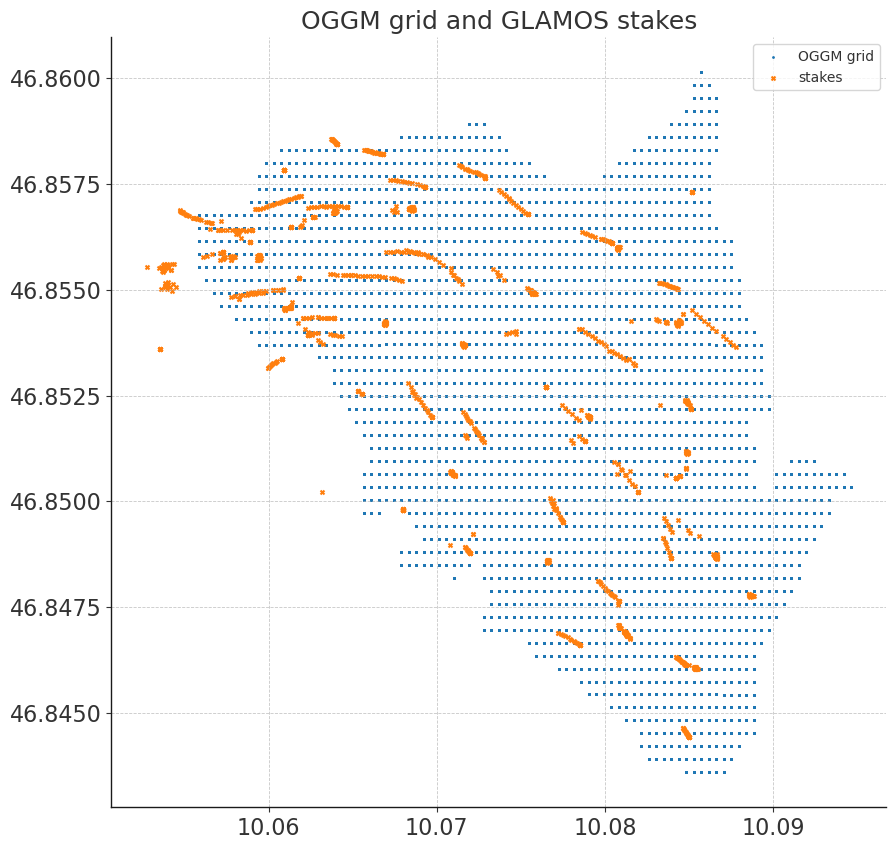

In [67]:
# Plot coordinates
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df_grid.POINT_LON, df_grid.POINT_LAT, s=1, label='OGGM grid')
ax.scatter(data_silvretta.POINT_LON,
           data_silvretta.POINT_LAT,
           s=8,
           label='stakes',
           marker='x')
ax.legend()
ax.set_title('OGGM grid and GLAMOS stakes')

### Add climate variables:

In [68]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']
meta_data_columns = ["RGIId", "POINT_ID", "ID", "N_MONTHS", "MONTHS", "PERIOD"]

RUN = True
if RUN == True:
    # Provide the column name for the column that has the RGI IDs for each of the stakes
    dataset_grid = mbm.Dataset(data=df_grid,
                               region_name='CH',
                               data_path=path_PMB_GLAMOS_csv)

    # Add climate data:
    # Specify the files of the climate data, that will be matched with the coordinates of the stake data
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

    # Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
    dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                      geopotential_data=geopotential_data,
                                      change_units=True)

    # For each record, convert to a monthly time resolution
    dataset_grid.convert_to_monthly(meta_data_columns=meta_data_columns,
                                    vois_climate=vois_climate,
                                    vois_topographical=voi_topographical)

    # Save grid:
    dataset_grid.data.to_csv(path_glacier_grid + 'Silvretta_grid.csv', index=False)

else:
    dataset_grid = pd.read_csv(path_glacier_grid + 'Silvretta_grid.csv')

# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=dataset_grid,
                            random_seed=SEED,
                            meta_data_columns=meta_data_columns)